# Inicialização

In [ ]:
try:
    import google.colab
    import requests
    url = 'https://raw.githubusercontent.com/dvgodoy/PyTorchStepByStep/master/config.py'
    r = requests.get(url, allow_redirects=True)
    open('config.py', 'wb').write(r.content)
except ModuleNotFoundError:
    pass

from config import *
config_chapter6()
# This is needed to render the plots in this chapter
from plots.chapter6 import *


Finished!


In [ ]:
import numpy as np
from PIL import Image
from copy import deepcopy

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, TensorDataset, random_split
from torchvision.transforms.v2 import Compose, ToImage, Normalize, \
ToPILImage, Resize, ToDtype
from torchvision.datasets import ImageFolder
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, \
MultiStepLR, CyclicLR, LambdaLR

from stepbystep.v2 import StepByStep
from data_generation.rps import download_rps

In [ ]:
download_rps()

rps folder already exists!
rps-test-set folder already exists!


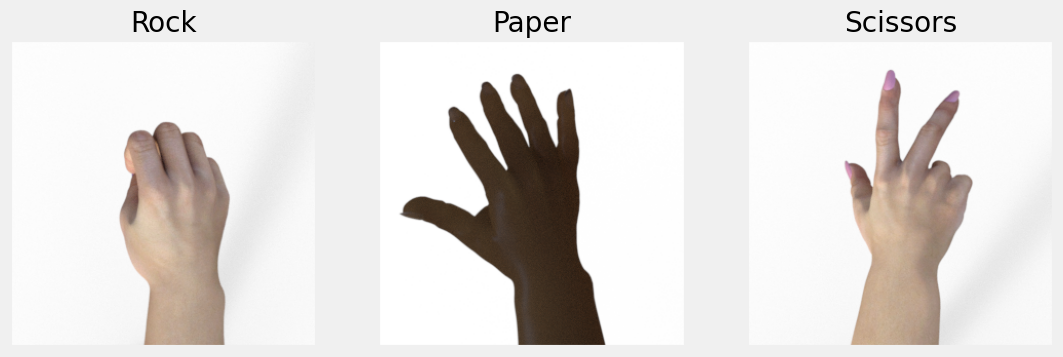

In [ ]:
fig = figure1()

In [ ]:
temp_transform = Compose([Resize(28), ToImage(), ToDtype(torch.float32, scale=True)])
temp_dataset = ImageFolder(root='rps', transform=temp_transform)


temp_dataset[0][0].shape, temp_dataset[0][1]

(torch.Size([3, 28, 28]), 0)

In [ ]:
@staticmethod
def statistics_per_channel(images, labels):
    # NCHW
    n_samples, n_channels, n_height, n_weight = images.size()
    # Flatten HW into a single dimension
    flatten_per_channel = images.reshape(n_samples, n_channels, -1)

    # Computes statistics of each image per channel
    # Average pixel value per channel
    # (n_samples, n_channels)
    means = flatten_per_channel.mean(axis=2)
    # Standard deviation of pixel values per channel
    # (n_samples, n_channels)
    stds = flatten_per_channel.std(axis=2)

    # Adds up statistics of all images in a mini-batch
    # (1, n_channels)
    sum_means = means.sum(axis=0)
    sum_stds = stds.sum(axis=0)
    # Makes a tensor of shape (1, n_channels)
    # with the number of samples in the mini-batch
    n_samples = torch.tensor([n_samples]*n_channels).float()

    # Stack the three tensors on top of one another
    # (3, n_channels)
    return torch.stack([n_samples, sum_means, sum_stds], axis=0)

setattr(StepByStep, 'statistics_per_channel', statistics_per_channel)

In [ ]:
@staticmethod
def make_normalizer(loader):
    total_samples, total_means, total_stds = StepByStep.loader_apply(loader, StepByStep.statistics_per_channel)
    norm_mean = total_means / total_samples
    norm_std = total_stds / total_samples
    return Normalize(mean=norm_mean, std=norm_std)

setattr(StepByStep, 'make_normalizer', make_normalizer)

In [ ]:
# Loads temporary dataset to build normalizer
temp_transform = Compose([Resize(28), ToImage(), ToDtype(torch.float32, scale=True)])
temp_dataset = ImageFolder(root='rps', transform=temp_transform)
temp_loader = DataLoader(temp_dataset, batch_size=16)
normalizer = StepByStep.make_normalizer(temp_loader)

# Builds transformation, datasets and data loaders
composer = Compose([Resize(28),
                    ToImage(),
                    ToDtype(torch.float32, scale=True),
                    normalizer])

train_data = ImageFolder(root='rps', transform=composer)
val_data = ImageFolder(root='rps-test-set', transform=composer)

# Builds a loader of each set
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16)

In [ ]:
class CNN2(nn.Module):
    def __init__(self, n_feature, p=0.0):
        super(CNN2, self).__init__()
        self.n_feature = n_feature
        self.p = p
        # Creates the convolution layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=n_feature, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=n_feature, out_channels=n_feature, kernel_size=3)
        # Creates the linear layers
        # Where do this 5 * 5 come from?! Check it below
        self.fc1 = nn.Linear(n_feature * 5 * 5, 50)
        self.fc2 = nn.Linear(50, 3)
        # Creates dropout layers
        self.drop = nn.Dropout(self.p)

    def featurizer(self, x):
        # Featurizer
        # First convolutional block
        # 3@28x28 -> n_feature@26x26 -> n_feature@13x13
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        # Second convolutional block
        # n_feature * @13x13 -> n_feature@11x11 -> n_feature@5x5
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        # Input dimension (n_feature@5x5)
        # Output dimension (n_feature * 5 * 5)
        x = nn.Flatten()(x)
        return x

    def classifier(self, x):
        # Classifier
        # Hidden Layer
        # Input dimension (n_feature * 5 * 5)
        # Output dimension (50)
        if self.p > 0:
            x = self.drop(x)
        x = self.fc1(x)
        x = F.relu(x)
        # Output Layer
        # Input dimension (50)
        # Output dimension (3)
        if self.p > 0:
            x = self.drop(x)
        x = self.fc2(x)
        return x

    def forward(self, x):
        x = self.featurizer(x)
        x = self.classifier(x)
        return x

In [ ]:
torch.manual_seed(13)
model_cnn3 = CNN2(n_feature=5, p=0.5)
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')

In [ ]:
def make_lr_fn(start_lr, end_lr, num_iter, step_mode='exp'):
    if step_mode == 'linear':
        factor = (end_lr / start_lr - 1) / num_iter
        def lr_fn(iteration):
            return 1 + iteration * factor
    else:
        factor = (np.log(end_lr) - np.log(start_lr)) / num_iter
        def lr_fn(iteration):
            return np.exp(factor)**iteration
    return lr_fn

In [ ]:
def lr_range_test(self, data_loader, end_lr, num_iter=100, step_mode='exp', alpha=0.05, ax=None):
    # Since the test updates both model and optimizer we need to store
    # their initial states to restore them in the end
    previous_states = {'model': deepcopy(self.model.state_dict()),
                       'optimizer': deepcopy(self.optimizer.state_dict())}
    # Retrieves the learning rate set in the optimizer
    start_lr = self.optimizer.state_dict()['param_groups'][0]['lr']

    # Builds a custom function and corresponding scheduler
    lr_fn = make_lr_fn(start_lr, end_lr, num_iter)
    scheduler = LambdaLR(self.optimizer, lr_lambda=lr_fn)

    # Variables for tracking results and iterations
    tracking = {'loss': [], 'lr': []}
    iteration = 0

    # If there are more iterations than mini-batches in the data loader,
    # it will have to loop over it more than once
    while (iteration < num_iter):
        # That's the typical mini-batch inner loop
        for x_batch, y_batch in data_loader:
            x_batch = x_batch.to(self.device)
            y_batch = y_batch.to(self.device)
            # Step 1
            yhat = self.model(x_batch)
            # Step 2
            loss = self.loss_fn(yhat, y_batch)
            # Step 3
            loss.backward()

            # Here we keep track of the losses (smoothed)
            # and the learning rates
            tracking['lr'].append(scheduler.get_last_lr()[0])
            if iteration == 0:
                tracking['loss'].append(loss.item())
            else:
                prev_loss = tracking['loss'][-1]
                smoothed_loss = alpha * loss.item() + (1-alpha) * prev_loss
                tracking['loss'].append(smoothed_loss)

            iteration += 1
            # Number of iterations reached
            if iteration == num_iter:
                break

            # Step 4
            self.optimizer.step()
            scheduler.step()
            self.optimizer.zero_grad()

    # Restores the original states
    self.optimizer.load_state_dict(previous_states['optimizer'])
    self.model.load_state_dict(previous_states['model'])

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    else:
        fig = ax.get_figure()
    ax.plot(tracking['lr'], tracking['loss'])
    if step_mode == 'exp':
        ax.set_xscale('log')
    ax.set_xlabel('Learning Rate')
    ax.set_ylabel('Loss')
    fig.tight_layout()
    return tracking, fig

setattr(StepByStep, 'lr_range_test', lr_range_test)

In [ ]:
def set_optimizer(self, optimizer):
    self.optimizer = optimizer

setattr(StepByStep, 'set_optimizer', set_optimizer)

In [ ]:
setattr(StepByStep, 'scheduler', None)
setattr(StepByStep, 'is_batch_lr_scheduler', False)

def set_lr_scheduler(self, scheduler):
    # Makes sure the scheduler in the argument is assigned to the
    # optimizer we're using in this class
    if scheduler.optimizer == self.optimizer:
        self.scheduler = scheduler
        if (isinstance(scheduler, optim.lr_scheduler.CyclicLR) or
            isinstance(scheduler, optim.lr_scheduler.OneCycleLR) or
            isinstance(scheduler, optim.lr_scheduler.CosineAnnealingWarmRestarts)):
            self.is_batch_lr_scheduler = True
        else:
            self.is_batch_lr_scheduler = False

setattr(StepByStep, 'set_lr_scheduler', set_lr_scheduler)

# Cenário 1: SGD vs Adam (Sem Schedulers)

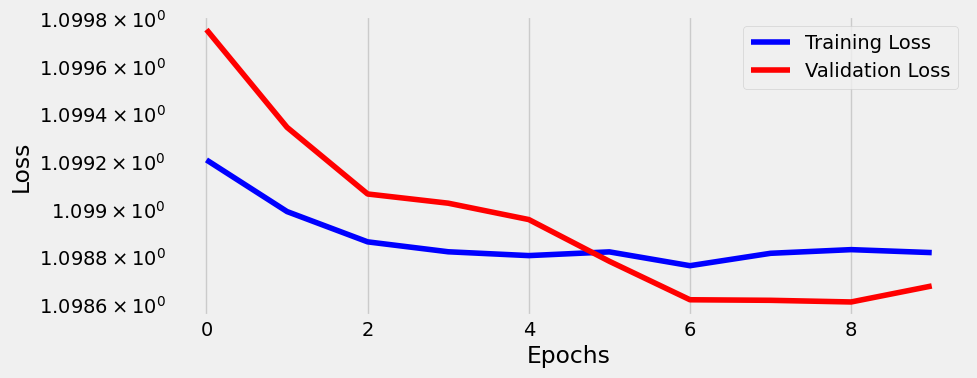

In [ ]:
sbs_cnn3 = StepByStep(model_cnn3, multi_loss_fn, optimizer_cnn3)

optimizer_cnn3 = optim.SGD(model_cnn3.parameters(), lr=0.01)
sbs_cnn3.set_optimizer(optimizer_cnn3)

sbs_cnn3.set_loaders(train_loader, val_loader)
sbs_cnn3.train(10)

fig = sbs_cnn3.plot_losses()

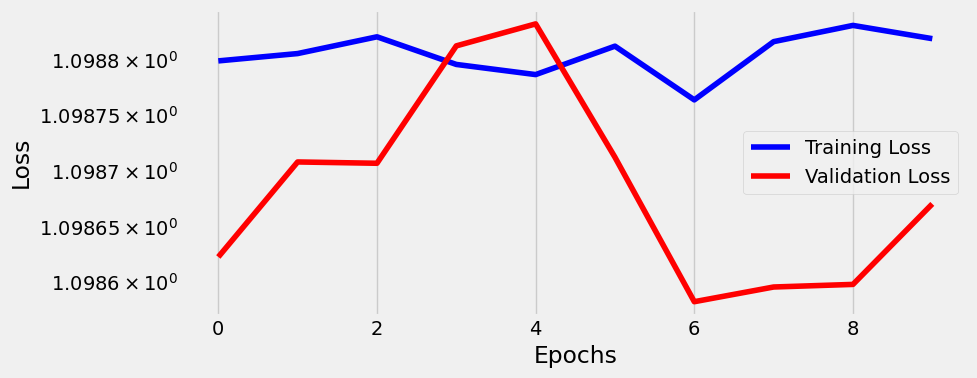

In [ ]:
sbs_cnn4 = StepByStep(model_cnn3, multi_loss_fn, optimizer_cnn3)

optimizer_cnn4 = optim.Adam(model_cnn3.parameters(), lr=0.01)
sbs_cnn4.set_optimizer(optimizer_cnn4)

sbs_cnn4.set_loaders(train_loader, val_loader)
sbs_cnn4.train(10)

fig = sbs_cnn4.plot_losses()

# Cenário 2: SGD com Momentum vs Nesterov (Sem Schedulers)

In [ ]:
sbs_cnn5 = StepByStep(model_cnn3, multi_loss_fn, optimizer_cnn5)

optimizer_cnn5 = optim.SGD(model_cnn3.parameters(), lr=0.01, momentum=0.9, nesterov=False)
sbs_cnn5.set_optimizer(optimizer_cnn5)

sbs_cnn5.set_loaders(train_loader, val_loader)
sbs_cnn5.train(10)

fig = sbs_cnn5.plot_losses()

KeyboardInterrupt: 

In [ ]:
sbs_cnn6 = StepByStep(model_cnn3, multi_loss_fn, optimizer_cnn3)

optimizer_cnn6 = optim.SGD(model_cnn3.parameters(), lr=0.01, momentum=0.9, nesterov=True)
sbs_cnn6.set_optimizer(optimizer_cnn6)

sbs_cnn6.set_loaders(train_loader, val_loader)
sbs_cnn6.train(10)

fig = sbs_cnn6.plot_losses()

# Cenário 3: Nesterov com StepLR vs Nesterov com CyclicLR

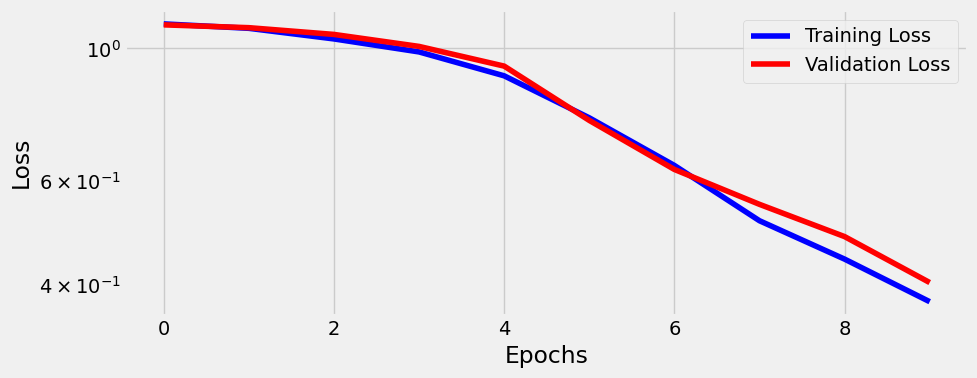

In [ ]:
optimizer_cnn7 = optim.SGD(model_cnn3.parameters(), lr=0.01, momentum=0.9, nesterov=True)

sbs_cnn7 = StepByStep(model_cnn3, multi_loss_fn, optimizer_cnn7)
sbs_cnn7.set_optimizer(optimizer_cnn7)


scheduler = CyclicLR(optimizer_cnn7, base_lr=1e-3, max_lr=0.01, step_size_up=len(train_loader), mode='triangular2')
sbs_cnn7.set_lr_scheduler(scheduler)

sbs_cnn7.set_loaders(train_loader, val_loader)
sbs_cnn7.train(10)

fig = sbs_cnn7.plot_losses()

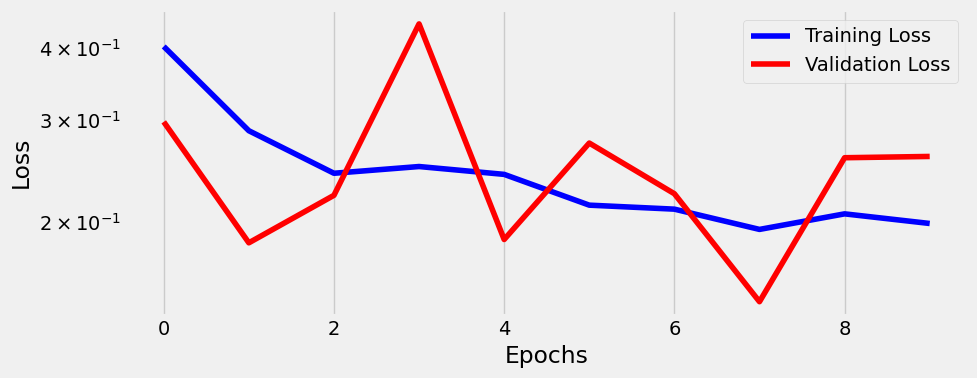

In [ ]:

optimizer_cnn8 = optim.SGD(model_cnn3.parameters(), lr=0.01, momentum=0.9, nesterov=True)

sbs_cnn8 = StepByStep(model_cnn3, multi_loss_fn, optimizer_cnn8)
sbs_cnn8.set_optimizer(optimizer_cnn8)


scheduler = StepLR(optimizer_cnn8, step_size=len(train_loader), gamma=0.1)
sbs_cnn8.set_lr_scheduler(scheduler)

sbs_cnn8.set_loaders(train_loader, val_loader)
sbs_cnn8.train(10)

fig = sbs_cnn8.plot_losses()